In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#
%cd "/content/drive/MyDrive/IA/2doparcial/IA/EtregableImg"
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/IA/2doparcial/IA/EtregableImg
 Examples  'Loaded pokemon.ipynb'   poke.h5   pokemon   Pokemon   pokemon.ipynb


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

#Procesamiento de datos
Nuestro dataset ya se encuentra dividido en test, train y validation, por lo que solo es necesario acceder a ellos por medio del path para poder procesarlos.

In [ ]:
train_path = 'Pokemon/train'
validation_path = 'Pokemon/valid'
test_path = 'Pokemon/test'

En este caso manejaremos un dataset de tipos de pokemon, siendo dividido en 4 clases:

*   squirtle
*   charmander
*   bulbasaur
*   pikachu


Por lo tanto deberemos manejar un modelo categórico, pues son 4 categorias.

Se utilizó como base el modelo VGG para el entrenamiento del modelo.

POR QUE?
Elegí la arquitectura VGG debido a su profundidad y capacidad para extraer rasgos complejos. Con sus capas convolucionales, es perefecto para entender las características visuales en conjuntos de datos pequeños, como las 5 categorías de Pokémon. Ofrece un equilibrio entre desempeño y complejidad, siendo eficaz en el reconocimiento detallado de imágenes, pero sin la complejidad excesiva en su implementación y entrenamiento

In [ ]:
train_datagen = ImageDataGenerator(
							rescale = 1./255)
"""							rotation_range = 40,
							width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.2,
							zoom_range = 0.2,
							horizontal_flip = True,"""

train_generator = train_datagen.flow_from_directory(
							train_path,
							target_size = (200, 200),
							batch_size = 20,
							class_mode ='categorical')

val_datagen = ImageDataGenerator(1./255)

val_generator = val_datagen.flow_from_directory(
							validation_path,
							target_size = (200,200),
							batch_size =20,
							class_mode= 'categorical')

test_datagen = ImageDataGenerator(1./255)

test_generator = test_datagen.flow_from_directory(
							test_path,
							target_size = (200, 200),
							batch_size = 20,
							class_mode= 'categorical')

conv_base= VGG16(weights='imagenet',
							include_top = False,
							input_shape = (200,200,3))

Found 1403 images belonging to 4 classes.
Found 577 images belonging to 4 classes.
Found 321 images belonging to 4 classes.


POR QUÉ SE HIZO LA CONFIGURACIÓN DE ARRIBA?

Como se pude observar, se está haciendo "Data augmentation" con un generados de datos de imagenes con KERAS, esto se hace para poder procesar y aumentar el conjunto de datos antes de correr y alimentar la red nuronal

Se puede ver que resacalamos las imagenes de entrenamiento de 1 a 255, abajo se ven lineas de código comentadas, pues esas eran otras configuarciones para el preprocesado de los datos de entrenamiento, se buscaba hacer zoon, shiftear los rangos de tamaño, rotas la imagen, etc. pero se eliminó dicha configuración porque llegaba a hacer un poco inexacto el modelo

La red preentrenada (tranfer learning) en el conjunto de datos ImageNet se utiliza como base para extraer características de las imágenes de Pokemon en un tamaño de 200x200 píxeles

#Primera iteración


##Preparación del modelo


Para la primera iteración se utilizó un modelo secuencial, nuevamente, tomando como base VGG. Dado que la base ya fue previamente entrenada, el parámetro para que siga aprendiendo será falso.


POR QUÉ SE HIZO LA CONFIGURACIÓN DE ABAJO?

Se agrega convbase, que es la red preentrenada como base del modelo. Se emplea Flatten para aplanar las características extraídas para las capa de relu y softmax. Luego, se añaden capas densas (fully connected) para realizar la clasificación, una capa con 256 neuronas y función de activación ReLU para caracteristicas abstractas, seguida de una capa de regularización Dropout para prevenir el overfitting. La capa final, con activación softmax, tiene 4 neuronas para clasificar entre las 4 clases

In [ ]:
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(4,activation='softmax'))

conv_base.trainable = False

model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 18432)             0         
                                                                 
 dense_22 (Dense)            (None, 256)               4718848   
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 19434564 (74.14 MB)
Trainable params: 4719876 (18.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Al compilar el modelo se utilizará el RMSprop como optimizer, con una tasa de aprendizaje de 0.0002.

RMSprop trabaja manteniendo un promedio móvil sobre el cuadrado de los gradientes y dividiendo el gradiente entre la raíz de este promedio.
La pérdida se calculará con un Cross Entropy categórico dado que estamos trabjando con diversas clases.

La medida de aprendizaje será en accurancy.

In [ ]:
model1.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Para el entrenamiento del modelo mantendremos 30 steps por cada época, con un total de 15 épocas.

En cuanto a la validación utilizaremos 25 steps.

In [ ]:
history = model1.fit(train_generator,
				steps_per_epoch = 30,
				epochs = 15,
				validation_data = val_generator,
				validation_steps = 25)

Epoch 1/10
30/30 [==============================] - 8s 219ms/step - loss: 1.2925 - acc: 0.4477 - val_loss: 5.9858 - val_acc: 0.5540
Epoch 2/10
30/30 [==============================] - 6s 206ms/step - loss: 0.7664 - acc: 0.7233 - val_loss: 3.2598 - val_acc: 0.7280
Epoch 3/10
30/30 [==============================] - 5s 179ms/step - loss: 0.5509 - acc: 0.8182 - val_loss: 1.8341 - val_acc: 0.8460
Epoch 4/10
30/30 [==============================] - 6s 189ms/step - loss: 0.3878 - acc: 0.8850 - val_loss: 1.5422 - val_acc: 0.8960
Epoch 5/10
30/30 [==============================] - 6s 203ms/step - loss: 0.3217 - acc: 0.9217 - val_loss: 1.0878 - val_acc: 0.9260
Epoch 6/10
30/30 [==============================] - 6s 193ms/step - loss: 0.2824 - acc: 0.9233 - val_loss: 1.3891 - val_acc: 0.9200
Epoch 7/10
30/30 [==============================] - 6s 202ms/step - loss: 0.2443 - acc: 0.9348 - val_loss: 1.4610 - val_acc: 0.9240
Epoch 8/10
30/30 [==============================] - 6s 196ms/step - loss: 0.

#Resultados

Guardamos los resultados del modelo en diferentes variables.

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(1, len(acc) + 1)

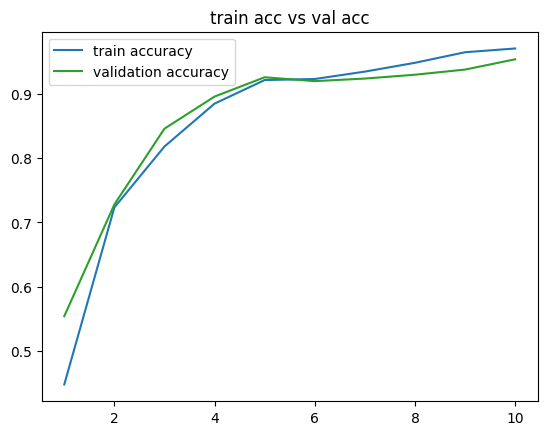

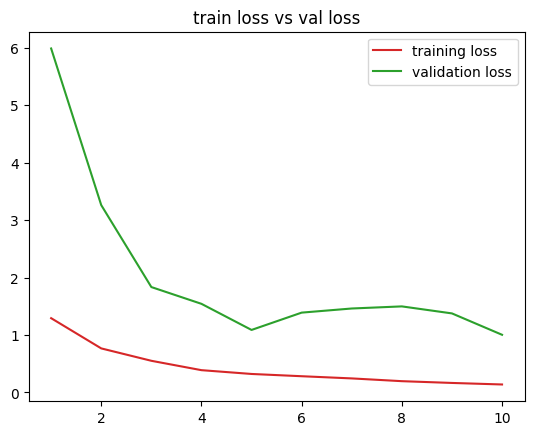

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs, acc, 'tab:blue', label='train accuracy')
plt.plot(epochs, val_acc, 'tab:green', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'tab:red', label='training loss')
plt.plot(epochs, val_loss, 'tab:green', label='validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()


GRAFICA 1

 La precisión de entrenamiento comienza en aproximadamente 0,4 y aumenta hasta aproximadamente 0,9 a medida que el modelo se entrena. La precisión de validación comienza en aproximadamente 0,6 y también aumenta hasta aproximadamente 0,9.

 En general, este es un buen resultado, pero es importante decir que la precisión de entrenamiento es ligeramente superior a la precisión de validación, esto puede ser una señal de que el modelo está sobreajustándose a los datos de entrenamiento

 Este es un buen resultado, pero es importante tener en cuenta las posibles señales de sobreajuste



 GRAFICA 2

 La pérdida de entrenamiento comienza en aproximadamente 0,1 y disminuye hasta aproximadamente 0,0 a medida que el modelo se entrena. La pérdida de validación comienza en aproximadamente 0,6 y también disminuye hasta aproximadamente 0,2


  La pérdida de entrenamiento y validación disminuye a medida que el modelo se entrena, lo que indica que el modelo está aprendiendo a realizar las tareas para las que fue diseñado


In [ ]:
test_loss, test_acc = model1.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc)

16/25 [==================>...........] - ETA: 1s - loss: 1.1809 - acc: 0.9500

25/25 [==============================] - 2s 85ms/step - loss: 1.1772 - acc: 0.9502

test acc :
 0.9501557350158691


#Segunda iteración
##Preparación del modelo
Para la segunda iteración se utilizó la misma base del modelo anterior, pues parecía apuntar a una dirección adecuada, por lo que se optó por ajustar los hiper parámetros.

In [ ]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(4,activation='softmax'))

conv_base.trainable = False

model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 18432)             0         
                                                                 
 dense_26 (Dense)            (None, 256)               4718848   
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 19434564 (74.14 MB)
Trainable params: 4719876 (18.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Al compilar el modelo se nuevamente se utilió el RMSprop como optimizer, pero ahora una tasa de aprendizaje de 0.0001.

La pérdida se calculará con un Cross Entropy categórico dado que estamos trabjando con diversas clases.

La medida de aprendizaje será en accurancy.

In [ ]:
model2.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=1e-5),
						metrics=['acc'])

Los parámetros de aprendizaje fueron incrementados para mejorar el rendimiento del modelo.

Se incrementaron a 40 los steps por cada época, con ahora un total de 20 épocas.

En cuanto a la validación utilizaremos 25 steps.

In [ ]:
history = model2.fit(train_generator,
				steps_per_epoch = 40,
				epochs = 20,
				validation_data = val_generator,
				validation_steps = 25)

Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 1.3898 - acc: 0.3972

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


40/40 [==============================] - 9s 207ms/step - loss: 1.3898 - acc: 0.3972 - val_loss: 5.4695 - val_acc: 0.5680
Epoch 2/20
40/40 [==============================] - 7s 179ms/step - loss: 0.9332 - acc: 0.6112 - val_loss: 2.9073 - val_acc: 0.7500
Epoch 3/20
40/40 [==============================] - 8s 197ms/step - loss: 0.6802 - acc: 0.7433 - val_loss: 1.7441 - val_acc: 0.8580
Epoch 4/20
40/40 [==============================] - 7s 188ms/step - loss: 0.5517 - acc: 0.7962 - val_loss: 1.5272 - val_acc: 0.8980
Epoch 5/20
40/40 [==============================] - 7s 175ms/step - loss: 0.4076 - acc: 0.8799 - val_loss: 1.2748 - val_acc: 0.9200
Epoch 6/20
40/40 [==============================] - 7s 175ms/step - loss: 0.3462 - acc: 0.9080 - val_loss: 1.1621 - val_acc: 0.9260
Epoch 7/20
40/40 [==============================] - 8s 190ms/step - loss: 0.3000 - acc: 0.9259 - val_loss: 1.0447 - val_acc: 0.9380
Epoch 8/20
40/40 [==============================] - 7s 176ms/step - loss: 0.2671 - acc:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(1, len(acc)+1)

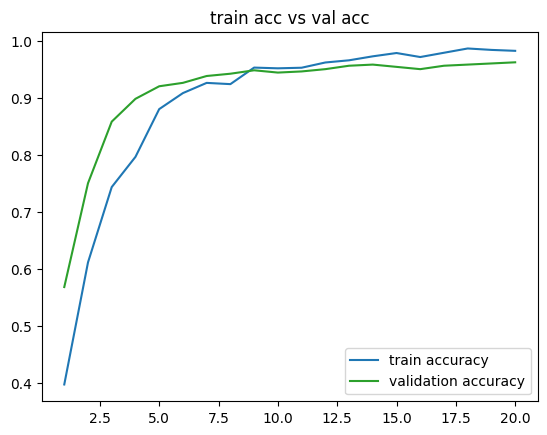

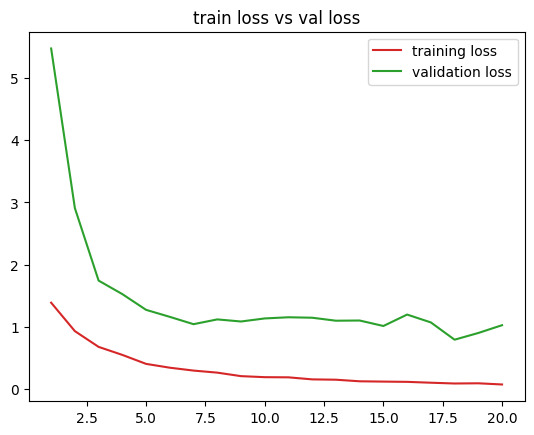

In [ ]:
plt.plot(epochs,acc,'tab:blue',label='train accuracy')
plt.plot(epochs,val_acc, 'tab:green', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'tab:red', label ='training loss')
plt.plot(epochs,val_loss, 'tab:green', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

GRAFICA 1

La precisión de entrenamiento comienza en aproximadamente 0,4 y aumenta hasta aproximadamente 0,9 a medida que el modelo se entrena. La precisión de validación comienza en aproximadamente 0,6 y también aumenta hasta aproximadamente 0,9

Pero al igual que el modelo pasado, es importante analisar las señales de sobreajuste, pues sigue teniendo la misma caracteristica.


GRAFICA 2

La pérdida de entrenamiento comienza en aproximadamente 0,2 y disminuye hasta aproximadamente 0,0 a medida que el modelo se entrena. La pérdida de validación comienza en aproximadamente 0,6 y también disminuye hasta aproximadamente 0,1


**EN COCLUSION**

Las dos últimas gráficas muestran una diferencia menos significativa entre la precisión de entrenamiento y la precisión de validación, lo que indica que el modelo es menos propenso a sobreajustarse a los datos de entrenamiento. Además, la pérdida de entrenamiento y validación se estabiliza después de un número relativamente pequeño de iteraciones de entrenamiento, lo que indica que el modelo está aprendiendo

In [ ]:
test_loss, test_acc = model2.evaluate(test_generator, steps = 50)
print('\ntest acc :\n', test_acc)

16/50 [========>.....................] - ETA: 4s - loss: 1.3141 - acc: 0.9469

50/50 [==============================] - 2s 38ms/step - loss: 1.3100 - acc: 0.9470

test acc :
 0.9470404982566833


In [ ]:
model2.save('poke.h5')

Finalmente se guarda el modelo para probarlo en otro programa.